# Introduction to Mesa

This notebook is based on the official tutorials of [Mesa](https://mesa.readthedocs.io). We have adapted it to suit the needs of a workshop we gave at the [Digital History 2023](https://dhistory.hypotheses.org/digital-history-tagung-2023/workshop-2) conference and flavored it to be more about history.

`Mesa` is a Python package for agent-based modeling which is relatively easy to get into and allows for a great amount of flexibility. In this tutorial, we will walk through creating a simple model and progressively add functionality which will illustrate some of `Mesa`'s core features.

The base for this tutorial is a very simple model of scholars exchanging letters in the 17th century. These will be our `agents`. For illustrative purposes, we will continue to call our agents `scholars`. Next, we add space to allow our `scholars` to move. Then, we’ll cover two of `Mesa`’s analytic tools: the data collector and the batch runner.

You can find examples of other simple models in the [examples directory](https://github.com/projectmesa/mesa-examples) of the Mesa repository.


# Model description

The tutorial model is a very simple simulated agent-based letter network. The rules of our tutorial model:

1. There are some number of agents, called `scholars`.

2. All `scholars` begin with 0 letters.

3. At every step of the model, a `scholar` sends a letter to some other `scholar`, based either on randomness or distance to the other `scholar`. 

Let’s get started!

In [3]:
"""To start with, let's import the mesa module"""
import mesa

## Setting up the model
To begin writing the model code, we start with two core classes: one for the overall `model`, the other for the `agents`. 

The model class holds the model-level attributes, for examples features of the environment, the passage of time, and any other feature that is not related to the agents themselves. It also manages the agents and generally handles the global level of our model. Each instantiation of the model class will be a specific model run. Each model will contain multiple agents, all of which are instantiations of the agent class. Both the model and agent classes are child classes of Mesa’s generic [Model and Agent classes](https://mesa.readthedocs.io/en/stable/apis/init.html).

In our code below, you can see simple versions of both model and agent as `class ScholarModel(mesa.Model)` or `class ScholarAgent(mesa.Agent)`.

For now, each `scholar` has only two variables: how many letters they have sent and how many they have received up until now. Each `scholar` will also have a unique identifier (usually a number), stored in the `unique_id` variable. Giving each agent a unique ID is a good practice when doing agent-based modeling.

```{admonition} Move this Note down to letter sending
Each of our `scholars` currently will keep diligent care of all their letters forever. In reality, letters might get lost, people might burn them if they can't stand the sender, and after a while others might get hold of them, either keeping them out of curiosity or just throwing them away. Others might even collect them systematically in an archive and eventually make exhibitions about them, if you are lucky!

This is the process of preservation and heritagization that in the end results in the source material we still have access to today. Our model here could also be used to model and study this process! 

Take a moment to think about how some kind of simple decay could be represented with python code in our `scholar` class.
```

There is only one model-level parameter: how many `scholars` the model contains. When a new model is started, we want it to populate itself with a given number of `scholars` ("N").

In [4]:
class ScholarAgent(mesa.Agent):
    """A 17th-century scholar with a fixed amount of initial letters, namely 0."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.letters_sent = 0
        self.letters_received = 0


class ScholarModel(mesa.Model):
    """A model with some number of scholars."""

    def __init__(self, N):
        self.num_agents = N
        # Create N number of agents
        for i in range(self.num_agents):
            a = ScholarAgent(i, self)

## Adding the scheduler 

Time in many agent-based models moves in steps, sometimes also called ticks. At each step of the model, one or more of the agents – usually all of them – are activated and take their own step, changing internally and/or interacting with one another or the environment.

The scheduler is a special model component which controls the order in which agents are activated. For example, all the agents may activate in the same order every step, their order might be shuffled, we may try to simulate all the agents acting at the same time, and more. `Mesa` offers a few different built-in scheduler classes, with a common interface. That makes it easy to change the activation regime a given model uses, and see whether it changes the model behavior. This may not seem important, but scheduling patterns can have an impact on your results (see Comer 2014).

For now, let's use one of the simplest ones: `RandomActivation`*, which activates all the `scholars` once per step, in random order. Every `scholar` is now expected to have a `step` method. 

The step method is the action an agent takes when it is activated by the model schedule. We add an agent to the schedule using the `add` method; when we call the schedule's `step` method, the model shuffles the order of the agents, then activates and executes each agent's `step` method.

*Unlike `mesa.model` or `mesa.agent`, `mesa.time` has multiple classes (e.g. `RandomActivation`, `StagedActivation` etc). To ensure context, time is used in the import as evidenced below with `mesa.time.Randomactivation`.  You can see the different time classes as [mesa.time](https://github.com/projectmesa/mesa/blob/main/mesa/time.py). 

With that in mind, the model code with the scheduler added looks like this:

In [5]:
class ScholarAgent(mesa.Agent):
    """A 17th-century scholar with a fixed amount of initial letters, namely 0."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.letters_sent = 0
        self.letters_received = 0

    def step(self):
        # The scholar's step will go here.
        # For demonstration purposes we will print the scholar's unique_id
        print("Good morrow! I am scholar " + str(self.unique_id) + ".")

class ScholarModel(mesa.Model):
    """A model with some number of scholars."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        # Create N number of agents
        for i in range(self.num_agents):
            a = ScholarAgent(i, self)
            self.schedule.add(a)
            
    def step(self):
        """Advance the model by one step."""
        self.schedule.step()

At this point, we have a model which runs – it just doesn’t do anything. You can see for yourself with a few easy lines:

In [6]:
empty_model = ScholarModel(10) # create a model with 10 agents
empty_model.step() # execute the step function once

Good morrow! I am scholar 4.
Good morrow! I am scholar 2.
Good morrow! I am scholar 1.
Good morrow! I am scholar 6.
Good morrow! I am scholar 7.
Good morrow! I am scholar 5.
Good morrow! I am scholar 0.
Good morrow! I am scholar 3.
Good morrow! I am scholar 8.
Good morrow! I am scholar 9.


## Agent Step

Now we just need to have the `scholars` do what we intend for them to do: send each other letters. 

To allow the `scholar` to choose another `scholar` at random, we use the `model.random` random-number generator. This works just like Python’s `random` module, but with a fixed seed set when the model is instantiated, that can be used to replicate a specific model run later.

To pick a `scholar` at random, we need a list of all `scholars`. Notice that there isn’t such a list explicitly in the model. The scheduler, however, does have an internal list of all the agents it is scheduled to activate.

With that in mind, we rewrite the `scholar`'s `step` method, like this:

In [7]:
class ScholarAgent(mesa.Agent):
    """A 17th-century scholar with a fixed amount of initial letters, namely 0."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.letters_sent = 0
        self.letters_received = 0

    def step(self):
        # Pick a random scholar from the scheduler, increase their letters received counter and increase your own letter sent counter
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.letters_received += 1
        self.letters_sent += 1

## Running your first model

With that last piece in hand, it’s time for the first rudimentary run of the model. Let’s create a model with 10 `scholars`, and run it for 10 steps.

In [8]:
model = ScholarModel(10)
for i in range(20):
    model.step()

You'll notice that nothing seemed to happen. Of course, we will have to have additional code to get some actual data out of the model!

Specifically, we want to see how many letters each `scholar` sent and received. We can get the letter's values with list comprehension and then use `matplotlib` (or another graphics library) to visualize the data in a histogram.

In [9]:
# import matplotlib for our visualization
import matplotlib.pyplot as plt

(array([1., 0., 2., 1., 0., 1., 1., 1., 0., 3.]),
 array([12. , 13.4, 14.8, 16.2, 17.6, 19. , 20.4, 21.8, 23.2, 24.6, 26. ]),
 <BarContainer object of 10 artists>)

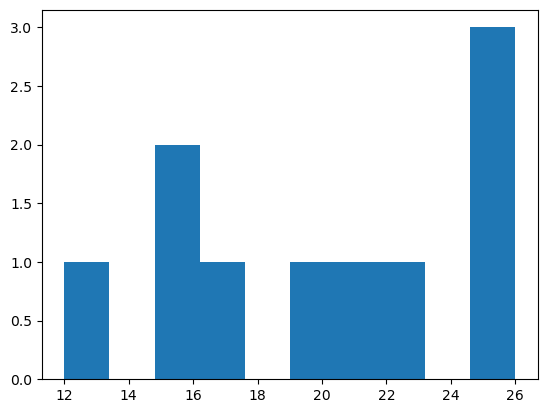

In [46]:
plt.show()

"""WHAT DOES THIS MEAN? EXPLAIN SOMEHWERE HERE"""


#agent_letters_sent = [a.letters_sent for a in model.schedule.agents]
agent_letters_recd = [b.letters_received for b in model.schedule.agents]

#plt.hist(agent_letters_sent)
plt.hist(agent_letters_recd)

You should see something like the distribution above. Yours will almost certainly look at least slightly different, since each run of the model is random, after all.

To get a better idea of how a model behaves, we can create multiple model runs and see the distribution that emerges from all of them. We can do this with a nested for loop:

(array([  0.,   0.,   3.,   9.,  13.,  37.,  48.,  96., 113., 132., 140.,
        110.,  95.,  77.,  55.,  32.,  18.,  14.,   8.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 <BarContainer object of 19 artists>)

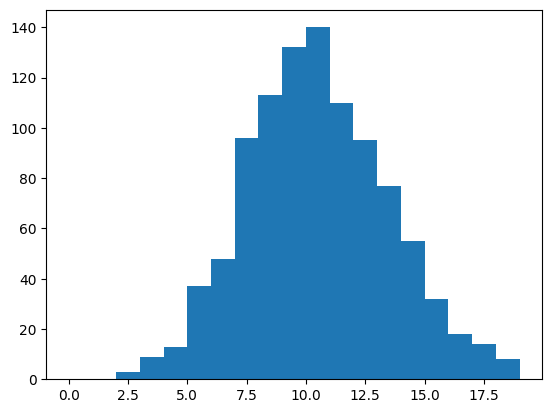

In [10]:
all_letters = []

# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = ScholarModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_letters.append(agent.letters_received)

#plot the results
plt.hist(all_letters, bins=range(max(all_letters) + 1))

This runs 100 instantiations of the model, and runs each for 10 steps (Notice that we set the histogram bins to be integers, since `scholars` can only have whole numbers of letters). This distribution looks a lot smoother. By running the model 100 times, we smooth out some of the ‘noise’ of randomness, and get to the model’s overall expected behavior.

For now, the letter distribution looks pretty normal (literally), because it is basically random. These results are not too surprising, yet. 

Let's add some more realistic behavior by introducing space between the `scholars` and let that influence their letter sending decision.

## [CONTINUE HERE]Adding space

Many ABMs have a spatial element, with agents moving around and interacting with nearby neighbors. Mesa currently supports two overall kinds of spaces:
`grid`, and `continuous`. Grids are divided into cells, and agents can only be on a particular cell, like pieces on a chess board. Continuous space, in contrast, allows agents to have any arbitrary position. Both grids and continuous spaces are frequently toroidal, meaning that the edges wrap around, with cells on the right edge connected to those on the left edge, and the top to the bottom. This prevents some cells having fewer neighbors than others, or agents being able to go off the edge of the environment.

Let’s add a simple spatial element to our model by putting our agents on a grid and make them walk around at random. Instead of sending a letter to any random agent, they’ll give it to an agent on the same cell.

Mesa has two main types of grids: `SingleGrid` and `MultiGrid`*. `SingleGrid` enforces at most one agent per cell; `MultiGrid` allows multiple agents to be in the same cell. Since we want agents to be able to share a cell, we use `MultiGrid`.

*However there are more types of space to include `HexGrid`, `NetworkGrid`, and the previously mentioned `ContinuousSpace`. Similar to `mesa.time` context is retained with `mesa.space.[enter class]`. You can see the different classes as `mesa.space`.

We instantiate a grid with width and height parameters, and a boolean as to whether the grid is toroidal. Let’s make width and height model parameters, in addition to the number of agents, and have the grid always be toroidal. We can place agents on a grid with the grid’s `place_agent` method, which takes an agent and an (x, y) tuple of the coordinates to place the agent.

In [48]:
class LetterModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = LetterAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

Under the hood, each agent’s position is stored in two ways: the agent is contained in the grid in the cell it is currently in, and the agent has a `pos` variable with an (x, y) coordinate tuple. The `place_agent` method adds the coordinate to the agent automatically.

Now we need to add to the agents’ behaviors, letting them move around and only send letters to other agents in the same cell.

First let’s handle movement, and have the agents move to a neighboring cell. The grid object provides a `move_agent` method, which like you’d imagine, moves an agent to a given cell. That still leaves us to get the possible neighboring cells to move to. There are a couple ways to do this. One is to use the current coordinates, and loop over all coordinates +/- 1 away from it. For example:

```python
neighbors = []
x, y = self.pos
for dx in [-1, 0, 1]:
    for dy in [-1, 0, 1]:
        neighbors.append((x+dx, y+dy))
```

But there’s an even simpler way, using the grid’s built-in `get_neighborhood` method, which returns all the neighbors of a given cell. This method can get two types of cell neighborhoods: [Moore](https://en.wikipedia.org/wiki/Moore_neighborhood) (includes all 8 surrounding squares), and [Von Neumann](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood) (only including the 4 top, bottom, left and right neighboring squares). It also needs an argument as to whether to include the center cell itself as one of the neighbors.

With that in mind, the agent’s move method looks like this:

```python
class LetterAgent(mesa.Agent):
   #...
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
```

Next, we need to get all the other agents present in a cell, and sent them a letter. We can get the contents of one or more cells using the grid's `get_cell_list_contents` method, or by accessing a cell directly. The method accepts a list of cell coordinate tuples, or a single tuple if we only care about one cell.

```python
class LetterAgent(mesa.Agent):
    #...
    def send_letter(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.letters_received += 1
            self.letters_sent -= 1
```

And with those two methods, the agent's ``step`` method becomes:

```python
class LetterAgent(mesa.Agent):
    # ...
    def step(self):
        self.move()
        self.send_letter()
```

Now, putting that all together should look like this:

In [49]:
class LetterAgent(mesa.Agent):
    """An agent with letters sent and received."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.letters_sent = 0
        self.letters_received = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def send_letter(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.letters_received += 1
            self.letters_sent += 1

    def step(self):
        self.move()
        self.send_letter()


class LetterModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = LetterAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

Let's create a model with 50 agents on a 10x10 grid, and run it for 20 steps.

In [50]:
model = LetterModel(50, 10, 10)
for i in range(20):
    model.step()

Now let's use `matplotlib` and `numpy` to visualize the number of agents residing in each cell. To do that, we create a numpy array of the same size as the grid, filled with zeros. Then we use the grid object's `coord_iter()` feature, which lets us loop over every cell in the grid, giving us each cell's coordinates and contents in turn.

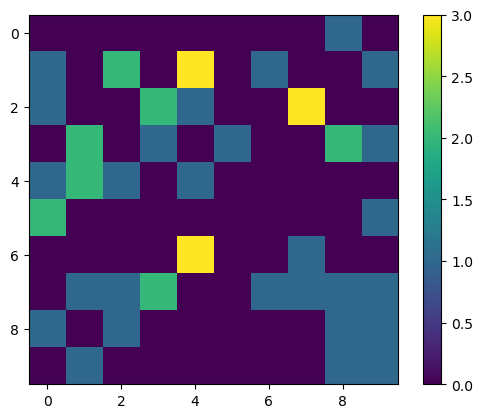

In [51]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()


### Collecting Data

So far, at the end of every model run, we've had to go and write our own code to get the data out of the model. This has two problems: it isn't very efficient, and it only gives us end results. If we wanted to know the letter counts of each agent at each step, we'd have to add that to the loop of executing steps, and figure out some way to store the data.

Since one of the main goals of agent-based modeling is generating data for analysis, Mesa provides a class which can handle data collection and storage for us and make it easier to analyze.

The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s `collect` method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s `unique_id`.

Let's add a `DataCollector` to the model with [`mesa.DataCollector`](https://github.com/projectmesa/mesa/blob/main/mesa/datacollection.py), and collect two variables at the agent level. We want to collect every agent's letters sent and letters received at every step.

In [52]:
class LetterAgent(mesa.Agent):
    """An agent with letters sent and letters received."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.letters_sent = 0
        self.letters_received = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def send_letter(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.letters_received += 1
            self.letters_sent += 1

    def step(self):
        self.move()
        self.send_letter()


class LetterModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = LetterAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            agent_reporters={"Letters_sent": "letters_sent", "Letters_received": "letters_received"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

At every step of the model, the datacollector will collect and store each agent's letters sent value.

We run the model just as we did above. The `DataCollector` can export the data its collected as a pandas `DataFrame`, for easy interactive analysis.

In [53]:
model = LetterModel(50, 10, 10)
for i in range(100):
    model.step()

We can now get the agent-letters data like this:

In [54]:
agent_letters = model.datacollector.get_agent_vars_dataframe()
agent_letters.tail()

Letters_sent  Letters_received
Step AgentID                                
99   45                 32                36
     46                 36                35
     47                 37                42
     48                 39                40
     49                 35                42

You'll see that the DataFrame's index is pairings of model step and agent ID. You can analyze it the way you would any other DataFrame. For example, to get a histogram of agent's letters sent at the model's end:

<AxesSubplot:>

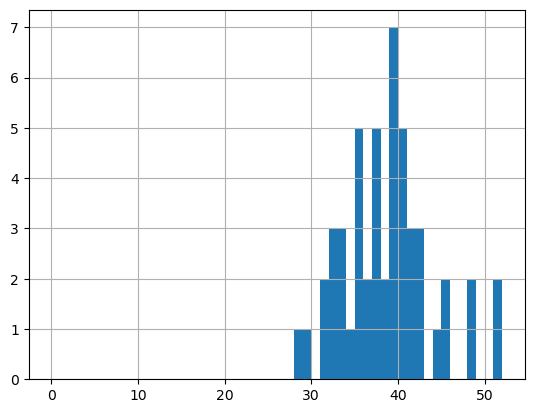

In [55]:
end_letters = agent_letters.xs(99, level="Step")["Letters_sent"]
end_letters.hist(bins=range(agent_letters.Letters_sent.max() + 1))

Or to plot the letters received of a given agent (in this example, agent 14):

<AxesSubplot:xlabel='Step'>

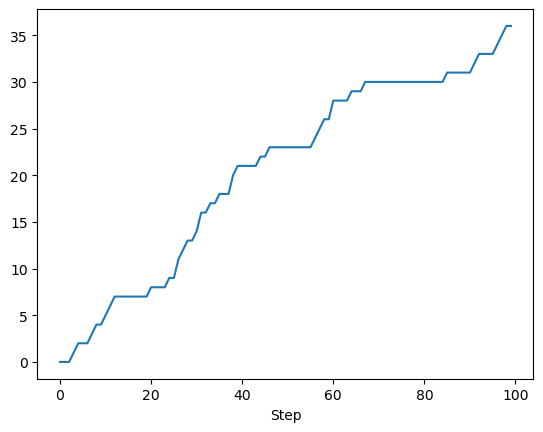

In [56]:
one_agent_letters = agent_letters.xs(14, level="AgentID")
one_agent_letters.Letters_received.plot()

You can also use `pandas` to export the data to a CSV (comma separated value), which can be opened by any common spreadsheet application or opened by `pandas`.

If you do not specify a file path, the file will be saved in the local directory. After you run the code below you will see two files appear (*model_data.csv* and *agent_data.csv*)

In [57]:
# save the agent data (stored in the pandas agent_letters object) to CSV
agent_letters.to_csv("agent_data.csv")

## Next steps and open questions

Now we have a very simple model where agents send each other letters when they are close enough to each other, but otherwise walking aimlessly through their grid-like world. Of course, this model does not yet capture actual letter sending in a meaningful way. 

In the real world, for example in the time of the Republic of Letters, people wouldn't have wandered at random, but maybe stayed at certain places and only on special, purposeful occasions change place. They would also know and remember the people they write to or receive letters from. Based on their familiarity and, crucially, the topical content of the communication, people would choose to write certain people more than others, not just their immediate neighbors. Out of this, an actually interesting social-epistemic network might arise and be analysed. 

All of these features would be possible to implement with python and the simple methods we mentioned here and most of these we actually tried to model in the projects actual LetterModel on which we will have a look at next!

If you want more information and a more thorough introduction to mesa, you can either head to [the documentation of mesa](https://mesa.readthedocs.io/en/stable/overview.html), which features a variant of this tutorial and more on advanced features, especially built-in javascript-based visualization methods, or you can head to youtube [for a video tutorial](https://www.youtube.com/playlist?list=PLF0b3ThojznRpQOd7iFukqXybbMV_vwZn) in a similar vein like the official mesa tutorials. 

### Literature

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf